![logo](./img/LogoLine_horizon_C3S.png)

# Looking at Sea Level and derived Surface Current data

This notebook-tutorial provides a practical introduction to the Sea level gridded data from satellite observations for the global ocean from 1993 to present data  available at the Climate Data Store (CDS). These datasets contain data for Essential Climate Variables (ECVs) Sea Level, as well as Surface Currents (the latter only in the daily dataset).
<br>
We give a short introduction to the Sea level data and to their derived surface currents. We provide two use cases of the datasets: plot the monthly Sea Level data during an El Niño event (Use Case 1), plot the Sea Level and derived parameters over a strong current (Use Case a).
We provide step-by-step instructions and each line of code is explained.

The notebook has two main use cases with the following outline:
## Table of Contents

* [Introduction](#introduction)
* [Prerequisites and data acquisition](#data)
* [Use Cases](#usecases)
    * [Use case 1: Monthly dataset and El Niño](#uc1)
    * [Use case 2: Daily dataset and the Gulf Stream](#uc2)
* [Key take-home learnings](#key)
* [Get more information about Sea Level](#references)

##  <a id="introduction">Introduction</a>


This tutorial is about Sea Level parameters of gridded Sea Level datasets. It covers step by step the process from retrieving the data to the visualisation of the resulting selection.

The Sea level gridded data from satellite observations for the global ocean from 1993 to present dataset provides sea surface heights values from radar altimetry satellites. The sea level dataset provided by C3S is climate-oriented, that is, dedicated to the monitoring of the long-term evolution of sea level and the analysis of the ocean/climate indicators, both requiring a homogeneous and stable sea level record. To achieve this, a steady two-satellite merged constellation is used at all time steps in the production system: one satellite serves as reference and ensures the long-term stability of the data record; the other satellite (which varies across the record) is used to improve accuracy, sample mesoscale processes and provide coverage at high latitudes. 

The C3S sea level dataset is used to produce Ocean Monitoring Indicators such as the mean sea level evolution, an important climate indicator, available in the CMEMS catalogue. Stability is also of importance when considering kinetic energy evolution in the ocean, as the addition of a satellite in the input data can add details in surface currents from which this quantity is computed, thus apparently changing the kinetic energy.


###  Data description


Satellite radar altimetry measure the distance between themselves and the water (or ice) surface, also called "<b>range</b>". Several independent instruments onboard the satellites provide with the satellite <b>altitude</b>, which enable to compute a sea surface height with respect to either the reference ellipsoid (a geometric surface approximating Earth surface), the geoid (an equipotential of the Earth gravity field), or a mean sea surface (thus including only variable heights) by subtracting the range from the altitude.


![logo](./img/names-heights.png)

<b>Figure 1.</b>Scheme of altimetry principle, to provide with the different names which will be used later on.        



Acronyms and notions used in this notebook (and any content dealing with sea level data from altimetry):
    
* <b>SLA</b> Sea Level Anomaly  (sea surface height with respect to a mean sea surface) represents __ocean variability__ (sometimes called SSHA).
* <b>ADT</b> Absolute Dynamic Topography  (sea surface height with respect to the geoid) represents the __heights linked to everything moving__ in the ocean, including the stable currents (often named 'sea surface height' by oceanographers, but this name is ambiguous without a reference given).
* <b>MSS</b> Mean Sea Surface is __a multi-year average of the sea surface heights with respect to a reference ellipsoid__ -- MSS is not provided in the C3S data.
* <b>MDT</b> Mean Dynamic Topography : ADT = SLA + MDT ; MDT is obtained through MSS - geoid and also drifter current velocity analysis. It represents __the heights linked to the mean stable currents__. It is now provided through CMEMS as an independent dataset.
* <b>EKE</b> Eddy Kinetic Energy: the kinetic energy computed from the geostrophic currents derived from the slope of the sea level anomalies.




In the ocean, surface topography gradients are related to pressure gradients and therefore to currents through [geostrophy]("https://en.wikipedia.org/wiki/Geostrophic_current")
    


![logo](./img/coriolis2_en.jpg)

<b>Figure 2.</b> Geostrophic currents around a (positive) relief in the sea surface height. These currents are generated by the balance between
the horizontal pressure gradient forces exerted by water masses and the effect of acceleration due to the Earth's rotation (Coriolis' force).

<br> 

Those currents are computed from derivatives of the sea surface height slope (either SLAs or ADTs; it can also be done with MDT heights).
In the two different direction ( zonal (longitude) component, meridional (latitude) component), the computation <b>outside of the Equatorial area</b> is:
    
* $ u = -\frac{g}{f} * \frac{d (sla)}{d y}$ <br>
* $ v = \frac{g}{f} * \frac{d (sla)}{d x}$  <br>
with g the gravitational constant, f the Coriolis frequency.

In the +/- 5°N band (Equatorial area), the computation is also done in the dataset, but by using second derivatives.

Two variants of the dataset are provided in the CDS, Daily and Monthly mean, which do not include exactly the same variables (we will examine their respective contents later on in this tutorial):
* in the Sea Level gridded daily products, currents are provided as total geostrophic currents (ADT gradients: ugos and vgos) and geostrophic current anomalies (SLA gradients, ugosa and vgosa).
* In the Monthly Mean products, you will find the kinetic energy, which is computed from them, equal to ( 1/2 * $\sqrt{u^2 + v^2)}$ ), but not the eastwards (aka zonal) and northwards (aka meridional) components of the geostrophic currents separately.


###  Dataset description

Please find further information about the datasets as well as the data in the Climate Data Store sections "Overview", "Download data" and "Documentation": 
* [Sea level gridded data from satellite observations for the global ocean from 1993 to present overview](https://cds.climate.copernicus.eu/datasets/satellite-sea-level-global?tab=overview)
* [Sea level gridded data from satellite observations for the global ocean from 1993 to present download data](https://cds.climate.copernicus.eu/datasets/satellite-sea-level-global?tab=download)
* [Sea level gridded data from satellite observations for the global ocean from 1993 to present documentation](https://cds.climate.copernicus.eu/datasets/satellite-sea-level-global?tab=documentation)
  

##  <a id="data">Prerequisites and data acquisition</a>

<div class="alert alert-block alert-success">
<b>Objective</b>

***  
* how to run this tutorial,
* lists necessary python libraries,
* guides you through the process of data preparation, i.e   how to download the data via CDS API, and get it ready to be used.
</div>  


### Prerequisites

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). To run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which is the easiest way to get all libraries installed.

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it:

You can install the CDS API by using `conda` :<br>
```!conda install cdsapi```  

Or by using `pip`:<br>
```!pip install cdsapi```  
<br>
We will be working with data in NetCDF format. To best handle NetCDF data we will use libraries for working with multidimensional arrays, in particular  <a href="http://xarray.pydata.org/en/stable/" target="_blank">Xarray</a>. We will also need libraries for plotting and viewing data, in this case, we will use <a href="https://matplotlib.org/stable/index.html" target="_blank">Matplotlib</a> and <a href="https://scitools.org.uk/cartopy/docs/latest/" target="_blank">Cartopy</a>. <a href="https://urllib3.readthedocs.io/en/stable/" target="_blank">urllib3</a> for disabling warnings for data download via CDS API.

In [1]:
#!pip install -q cdsapi

### Import libraries

The data have been stored in files written in NetCDF format. To best handle these, we will import the [Xarray](http://xarray.pydata.org/en/stable/) library which is specifically designed for manipulating multidimensional arrays in the field of geosciences. The libraries Matplotlib and Cartopy will also be imported for plotting and visualising the analysed data. We will also import the libraries [zipfile](https://docs.python.org/3/library/zipfile.html) to work with zip-archives, [OS](https://docs.python.org/3/library/os.html) to use OS-functions and pattern expansion, and [urllib3](https://urllib3.readthedocs.io/en/stable/) for disabling warnings for data download via CDS API.

In [1]:
# CDS API library
import cdsapi

# Libraries for working with multidimensional arrays
import xarray as xr
import numpy as np

# Library to work with zip-archives, OS-functions and pattern expansion
import zipfile
import os

# Libraries for plotting and visualising data (cartopy for mapping)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3
urllib3.disable_warnings()

### Preparing to use CDS API

This section provides all necessary settings and input data to successfully run the use cases, and produce the figures. 

When connecting to the page (<a href="https://cds-beta.climate.copernicus.eu/how-to-api">https://cds-beta.climate.copernicus.eu/how-to-api</a>) (having an account on the CDS), you'll have your key to copy-paste in the file

#### Set up CDS API credentials

We will request data from the CDS programmatically with the help of the [CDS API](https://confluence.ecmwf.int/display/CKB/Climate+Data+Store+%28CDS%29+infrastructure+and+API).  

We have defined our credentials in a .cdsapirc file, put in our user folder (users/name under windows,  $HOME/ under linux).

You can also do it without a credential file, by uncommenting the code in the following cell, and replacing `#########` with your API key. This is necessary if you are running the notebook on a cloud platform. 

If you are running it locally, though, using a credential file can be practical for you in the future, as it avoid filling the key in every python script using the CDS API you may wish to run. 

In [2]:
#URL = 'https://cds.climate.copernicus.eu/api'
#KEY = '###############'

Define a data folder on your computer. 

In [3]:
# Define the folder name to download the data in
DATADIR = 'datacds/'
# this will create the folder if it doesnt't already exist, or not if it already exists. 
os.makedirs(DATADIR, exist_ok=True)


## <a id="usecases">Use Cases</a>

### **Use Case 1**: <a id="uc1">Explore and plot a Monthly mean Gridded Sea Level file at the peak of an El Niño episode</a>

<div class="alert alert-block alert-success">
<b>Objective</b>

***  
* read the Sea Level Anomaly variable,
* overview what Sea Level Anomalies can show of the ocean dynamics,
* plot the Sea Level Anomalies.
</div>  

First of all we will get an overview of the data content by looking at its metadata. Then, we will examine Sea Level Anomalies by plotting the monthly-averaged global distribution. 
The data are stored in NetCDF format, and we will use the Xarray library to work with the data. 
We will then use Matplotlib and Cartopy to visualise the data.

We start by downloading a Monthly mean file from 2015/11, using the latest version of the data available as of this day (vDT2021).

In [4]:
# Define a filename for the zip file downloaded from the CDS
downloaded_zipfile = os.path.join(DATADIR, 'dataset-satellite-sea-level-global_monthly.zip')

Build the request we send to the CDS, by defining the dataset we are requesting, the "variable", date(s) and version (everything you can select in the "download" page of the Climate Data Store for this given dataset can be thus defined). Note that in this case "variable" refers to the dataset variants, i.e., either "Daily" or "Monthly mean".
We only choose one file in this tutorial, but, by adding other year(s) and/or month(s) in the lists, you could download more. You can also try other months to plot them.

In [5]:
dataset = "satellite-sea-level-global"
request = {
    'variable': ['monthly_mean'],
    'year': ['2015'],
    'month': ['11'],
    'version': 'vdt2021'
}

client = cdsapi.Client()
client.retrieve(dataset, request, downloaded_zipfile)

2025-01-28 12:27:45,050 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2025-01-28 12:27:45,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-28 12:27:45,052 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2025-01-28 12:27:45,053 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

9889bbfcb8fc289ef88473eb4232a236.zip:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

'datacds/dataset-satellite-sea-level-global_monthly.zip'

In [6]:
# browse through the data folder, and unzip the files existing there.
with zipfile.ZipFile(downloaded_zipfile, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)

# Ensure the filelist is in the correct order:
filelist = sorted(filelist)

# Merge all unpacked files into one (if more than one file) - here we have only one.
ds = xr.open_mfdataset(filelist, concat_dim='time', combine='nested')

NetCDF is a self-described format, i.e. it includes information ("metadata") to help describe and explain the data, such as explicit name (long_name), standardized name (standard_name), comment, units, min and max values, also default value, etc. Those information are called "attributes", and are specific to the file, or to each variable; they are mostly optional, but highly recommended; the "standardization" of the format makes some of them mandatory. It is part of Copernicus Services' requirements. 

We will list all the data variables defined within the file.

In [7]:
ds.data_vars

Data variables:
    crs               (time) int32 4B -2147483647
    climatology_bnds  (time, nv) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds          (time, latitude, nv) float32 6kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    lon_bnds          (time, longitude, nv) float32 12kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    sla               (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    eke               (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>

You see here two geophysical variables, "SLA" and "EKE". Both have (time, latitude, longitude) as dimensions. "Time" has only one value since we have only one file with one date.

We will have a look at some of the attributes of the data : the standard name and unit of the provided variables (note that the variables in the list above can have or not those attributes).

In [8]:
for v in ds.data_vars:
    try:
# the \t (tabulation) is here to space the information for easier reading 
        print(v, '\t', ds[v].attrs['standard_name'], '\t', ' in unit: ', ds[v].attrs['units'])
# if a variable has not a standard_name and/or a unit, it is skipped
    except Exception:
        pass

sla 	 sea_surface_height_above_sea_level 	  in unit:  m
eke 	 specific_kinetic_energy_of_sea_water 	  in unit:  cm2/s2


The first information is the variable name that we will call in the next cell, to plot it. The Standard names are homogeneizing vocabulary. Variable units are of course necessary to know, especially when they are not the SI unit proper but multiples or submultiples (such as cm2/s2 here).

#### Read and load a data variable for monthly Product: Sea Level Anomalies

To load a data variable, we just call it by its name. Moreover, we need longitude and latitude to plot it on a map. Those are included in the file as "dimensions", but can be called the same way (to list dimension, you can use "ds.dims").

In [9]:
# we subset the initial dataset at this date in SeaLevelAnom. Note that in the provided file you only have one date, thus we select the time of the data
# (set by default at 15th of each month)
SeaLevelAnom = ds['sla'].sel(time='2015-11-15')
# Finally, we upload and store the latitude and longitude so as to be able to call them later on
latitude = ds['latitude']
longitude = ds['longitude']

#### Plot the monthly data for Sea Level Anomaly for Nov. 2015

We will plot the Sea Level Anomalies in a "plate carree" projection (scale: longitude = latitude), see https://scitools.org.uk/cartopy/docs/latest/crs/projections.html.

We are keeping the default color scale minimum and maximum (i.e. the minimum and maximum value of the variable within the given file -- it could be different on another month).
The lands are colored in grey (lightgrey) and delimited by a 1-px line. 
We set the extent of the plot using the maximum and minimum longitude and latitude defined above. 
We add a color scale (colorbar), and a title; here we put the unit of the scale in the title, in a 16-size font.

In [10]:
lon_min=-180. ; lon_max=180. ; lat_min=-90. ; lat_max=90.

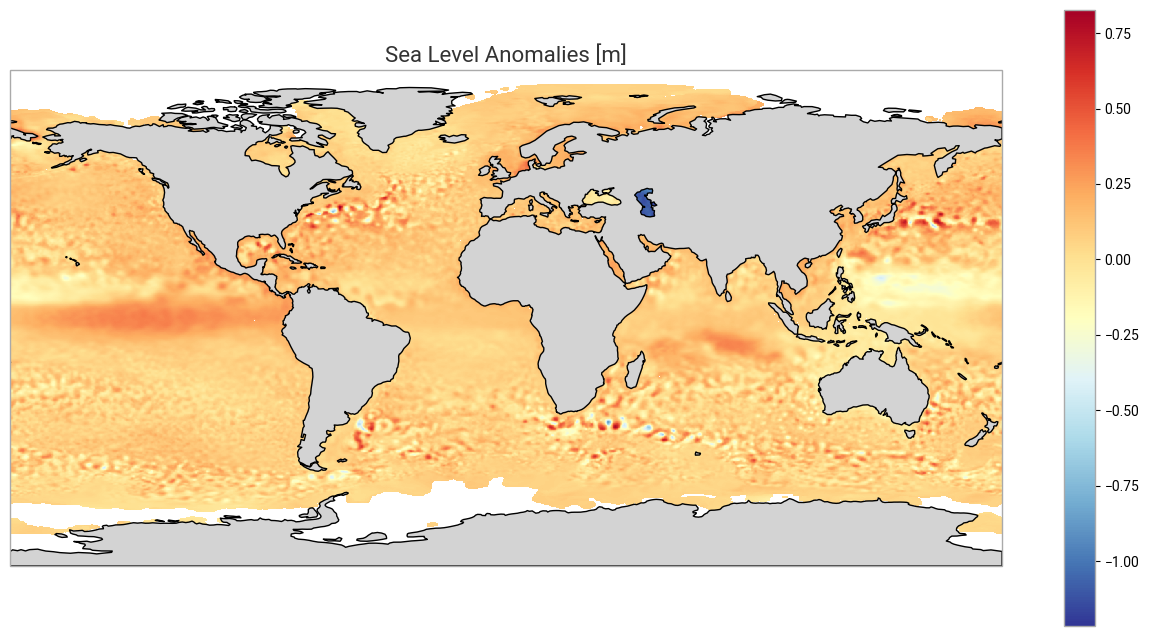

In [11]:
# Create python object from the "matplotlib" and its "pyplot" package (shortened as plt)
plt.figure(figsize=(16, 8))
# Create an "ax" from which we add the projection
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
# Add a layer for the continent
ax.add_feature(cfeature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# Set the extent of the map.
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
# Define a colormesh which is the color plot
mymap = ax.pcolormesh(longitude, latitude, SeaLevelAnom, cmap='RdYlBu_r', transform=ccrs.PlateCarree(central_longitude=0.), zorder=0)
# Add a colorbar to the map object to give scale
plt.colorbar(mymap, ax=ax)
# Add a title to the map object
plt.title('Sea Level Anomalies [m]', size=16)
plt.show()

**Figure 3.** This plot show the Sea Level Anomalies averaged for the month of November 2015.
A lot of "dots" are present. Red and blue 'dots', mostly concentrated in the major current areas (e.g. the Gulf Stream, Antarctic Circumpolar Current, Kuroshio Current, among others) are strong mesoscale eddies, anticyclonic for "red" dots (higher-than-average sea level anomalies, also warm eddies), cyclonic for "blue" dots (lower-than-average sea level anomalies, also cold eddies). Some of those are present in this monthly average since they typically last for more than 30 days (they are moving, though, during such period). These eddies are an important part of vertical mixing of the ocean, and have thus a role in climate processes.

However, you may also have noticed a large structure West of South America, but it is cut by the projection centered on 0. We will see how to change the map center, and look at that structure. Moreover, the whole map is somehow uniformly colored, and not centered on 0 - defining the minimum and maximum of the colorbar used will improve the readability of the map.

Center the map on the Pacific, and define the colorbar extrema to better see what is happening.

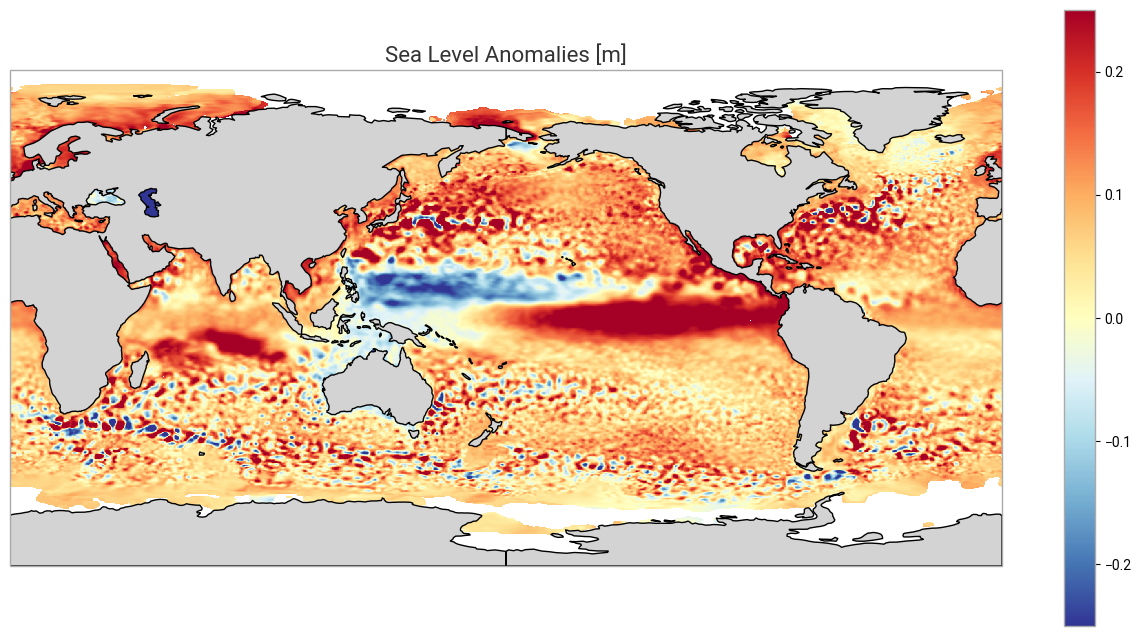

In [12]:
# Create python object from the "matplotlib" and its "pyplot" package (shortened as plt)
plt.figure(figsize=(16, 8))
# Create an "ax" from which we add the projection of the plot (here we make it centered on 180°E)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.))
# Add a layer for the continent - we place it over the ocean data using a "zorder" higher than for the data (resulting map is neater, 
# though it is not essential)
ax.add_feature(cfeature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# Set the extent of the map.
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
# Define the minimum and maximum of the colorbar. By default values above and below will be of the max and min color (resp)
minvalue = -0.25
maxvalue = 0.25
# Define a colormesh which is the color plot; note that the projection indicated (PlateCarree) is the projection of the data themselves
mymap = ax.pcolormesh(longitude, latitude, SeaLevelAnom, vmin=minvalue, vmax=maxvalue, cmap='RdYlBu_r', 
                      transform=ccrs.PlateCarree(central_longitude=0.), zorder=0)
# Add a colorbar to the map object to give scale
plt.colorbar(mymap, ax=ax)
# Add a title to the map object
plt.title('Sea Level Anomalies [m]', size=16)
plt.show()

**Figure 4.** We better see here the higher-than-average sea level anomalies in the Eastern Tropical Pacific which is one of the signature of an El Niño episode (counterbalanced by lower-than-average sea level anomalies in the Western Pacific). If you look at the previous months, you will see this anomaly crossing the whole Pacific, from West to East, from Asia to South America. 

### **Use case 2**: <a id="uc2">Explore and plot a daily Gridded Sea Level file over the Gulf Stream area</a>

<div class="alert alert-block alert-success">
<b>Objective</b>

***  
* read different variables within a daily file,
* overview what those different variables can show of the ocean dynamics,
* compute a vector magnitude from its two components (current velocities)
* plot them.
</div>  

#### Read and load a data variable for daily Product

We will open and explore a daily file, chosen on June 7, 2023 - the date is purely arbitrary, you can try another one from January 1st, 1993 to the latest available one (at the time of writing, June 7, 2023).

The beginning of the process is exactly the same than above, except the variant name ("variable") of the dataset requested which is now "daily", and that we add a day in the month for the date. 

In [13]:
# Filename for the zip file downloaded from the CDS
downloaded_zipfiledaily = os.path.join(DATADIR, 'dataset-satellite-sea-level-global_daily.zip')

mydate = '2023-06-07'

In [14]:
dataset = "satellite-sea-level-global"
request = {
    'variable': ['daily'],
    'year': ['2023'],
    'month': ['06'],
    'day': ['07'],
    'version': 'vdt2021'
}
client = cdsapi.Client()
client.retrieve(dataset, request, downloaded_zipfiledaily)

2025-01-28 12:28:26,971 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2025-01-28 12:28:26,972 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-01-28 12:28:26,973 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2025-01-28 12:28:26,974 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

a80174da92ff698d79f2824e8d1969a3.zip:   0%|          | 0.00/9.25M [00:00<?, ?B/s]

'datacds/dataset-satellite-sea-level-global_daily.zip'

In [15]:
with zipfile.ZipFile(downloaded_zipfiledaily, 'r') as zip_ref:
    filelist = [os.path.join(DATADIR, f) for f in zip_ref.namelist()]
    zip_ref.extractall(DATADIR)

# Ensure the filelist is in the correct order:
filelistdaily = sorted(filelist)

# Merge all unpacked files into one (if more than one file) - here we have only one
dsdaily = xr.open_mfdataset(filelistdaily, concat_dim='time', combine='nested')

Let's see what data variables we now have - again, the instruction is the same than above, but not the resulting list. 

In [16]:
dsdaily.data_vars

Data variables:
    crs             (time) int32 4B -2147483647
    lat_bnds        (time, latitude, nv) float32 6kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    lon_bnds        (time, longitude, nv) float32 12kB dask.array<chunksize=(1, 50, 2), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    err_ugosa       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    vgosa           (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    err_vgosa       (time, latitude, longitude) float64 8MB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    adt             (time, latitude, longitude) float64 8MB da

You can see that they are more variables in this dataset variant. SLA is still here, but in the case of daily data, the EKE is not pre-computed. However, you have zonal (U) and meridional (V) components of the geostrophic velocity derived from the Sea Level Anomalies (ugosa, vgosa). You also have the absolute dynamic topography (ADT) and the corresponding geostrophic velocities (ugos, vgos). Let's have a look at all those, and compute th current velocity too, over the Gulf Stream area.

In [17]:
# the area of study: North-West Atlantic 
lon_min=-85. ; lon_max=-30. ; lat_min=15. ; lat_max=55.

Select only the area and save the dataset thus created in a netcdf file for future uses.

In [18]:
# We select the part of the dataset included between the maximum and minimum longitude (resp. latitude)
# as if we were cutting a "slice" of the data.
# pcolormesh interpolate, so you can add half a step in every direction (or you'll have a blank line all around your plot)
# the resolution is given in the attributes of the file, we can retrieve the information from there.
steplon = dsdaily.attrs['geospatial_lon_resolution']
steplat = dsdaily.attrs['geospatial_lat_resolution']

# extraction over an area - note that it will not work over an area with 180°E within
extrds = dsdaily.sel(longitude=slice(lon_min-(steplon/2), lon_max+(steplon/2)), latitude=slice(lat_min-(steplat/2), lat_max+(steplat/2)))

# we close the initial file, since we will be using the extraction only afterwards
dsdaily.close()

# Save the geographical subset into a new NetCDF file, using 'to_netcdf' for this
# we name the file gulfstream_YYYYMMDD.nc, using the date defined ealier. 
output_filename = 'gulfstream_' + mydate + '.nc'
extrds.to_netcdf( os.path.join(DATADIR, output_filename))

Have a look at the extracted data structure as a whole:

In [19]:
extrds

<xarray.Dataset> Size: 3MB
Dimensions:         (time: 1, latitude: 162, nv: 2, longitude: 222)
Coordinates:
  * time            (time) datetime64[ns] 8B 2023-06-07
  * latitude        (latitude) float32 648B 14.88 15.12 15.38 ... 54.88 55.12
  * longitude       (longitude) float32 888B -85.12 -84.88 ... -30.12 -29.88
  * nv              (nv) int32 8B 0 1
Data variables: (12/14)
    crs             (time) int32 4B -2147483647
    lat_bnds        (time, latitude, nv) float32 1kB dask.array<chunksize=(1, 31, 2), meta=np.ndarray>
    lon_bnds        (time, longitude, nv) float32 2kB dask.array<chunksize=(1, 21, 2), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    adt             (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
    tpa_correction  (time) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 288kB dask.array<chunksize=(1, 31, 21), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-06-07T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-06-06T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

Load the different sea surface height-related variables. First, we will plot the sea level anomalies (as for the monthly file) over our area of interest.

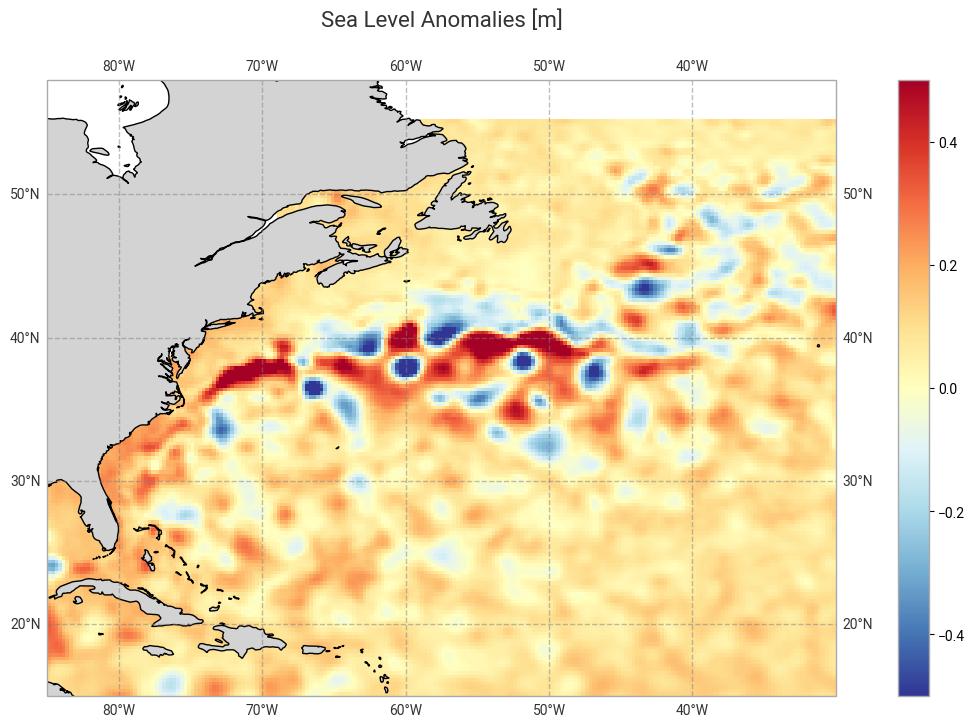

In [20]:
# loading of all the variables. We select by the time (again, only one date in this tutorial) 
adt = extrds['adt'].sel(time=mydate)
uadt = extrds['ugos'].sel(time=mydate)
vadt = extrds['vgos'].sel(time=mydate)
uvadt = np.sqrt(uadt**2 + vadt**2) # current velocity ; EKE = 1/2 * (uadt**2 + vadt**2)
sla = extrds['sla'].sel(time=mydate)
usla = extrds['ugosa'].sel(time=mydate)
vsla = extrds['vgosa'].sel(time=mydate)
uvsla = np.sqrt(usla**2 + vsla**2) # current velocity ;  EKE = 1/2 * (usla**2 + vsla**2)

latitude = extrds['latitude']
longitude = extrds['longitude']

plt.figure(figsize=(16, 8))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
# Add a layer for the continent - we place it over the ocean data using a "zorder" higher than for the data (resulting map is neater, it is not essential)
ax.add_feature(cfeature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
# Set the extent of the map.
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# Defining the min/max of the colorbar
minvalue = -0.5
maxvalue = 0.5
# Actually plot the data
mymap = ax.pcolormesh(longitude, latitude, sla, vmin=minvalue, vmax=maxvalue, cmap='RdYlBu_r', 
                      transform=ccrs.PlateCarree(central_longitude=0), zorder=0)
plt.colorbar(mymap, ax=ax)
plt.title('Sea Level Anomalies [m]', size=16, pad=24)
plt.show()


**Figure 5.** Sea Level Anomalies over the North-West Atlantic. The area with very high / very low "dots" (i.e., eddies) shows the turbulence of the Gulf Stream, with a number of eddies (and meanders of the current) thus visible. You may have noticed that we defined the minimum and maximum of the colorbar at lower/higher values than for the global monthly mean above, due to these higher/lower values.

Plot all the variables loaded or computed above, absolute dynamic topography (left) and anomalies (right), side by side.

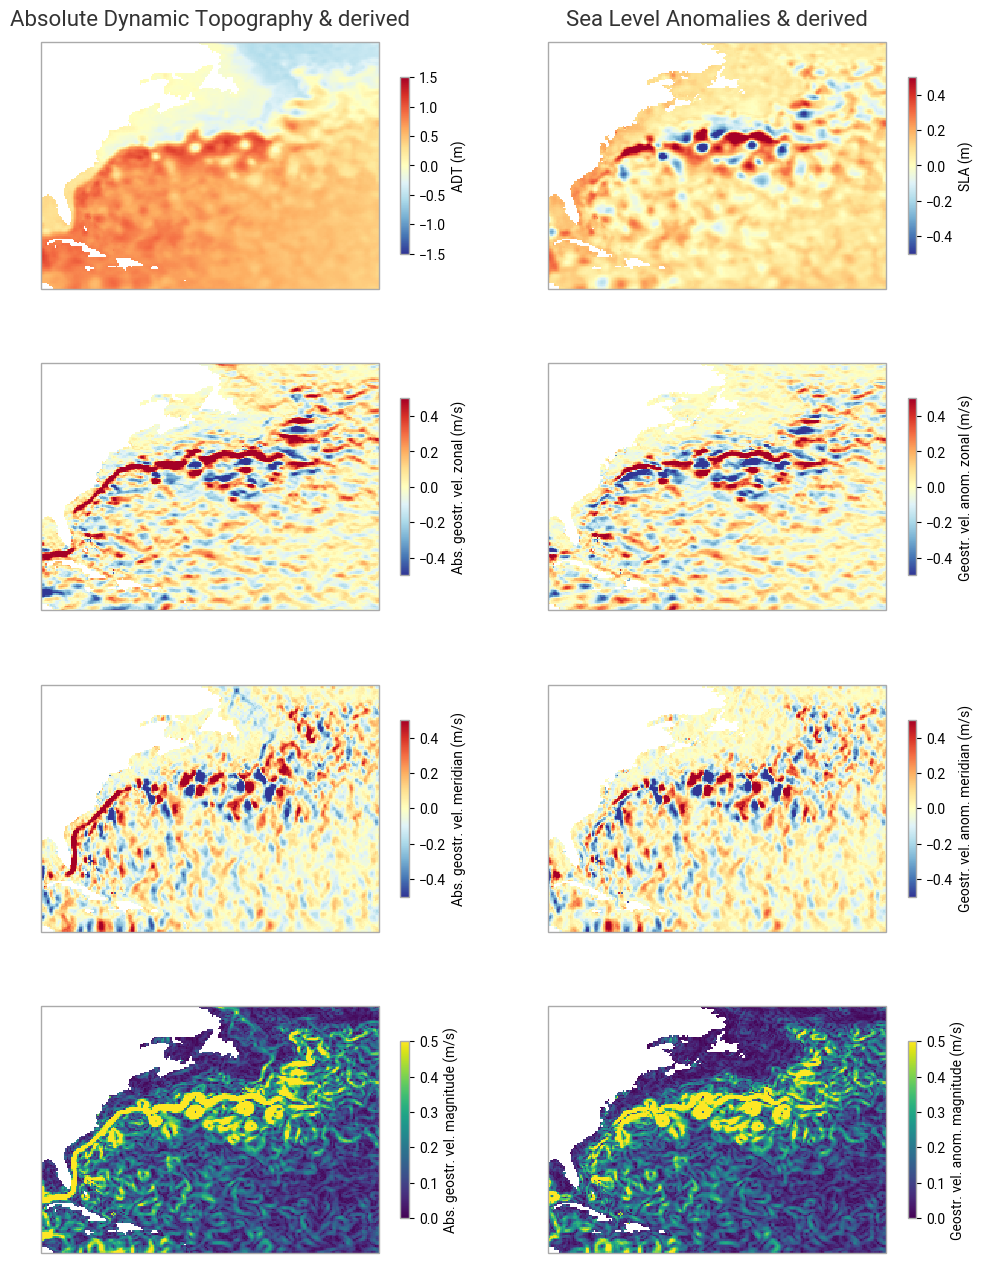

In [21]:
# Define a frame for subplots - 4 rows, 2 columns, all with the same projection
fig, axs = plt.subplots(nrows=4,ncols=2, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}, figsize=(12,16))

# Define the different subplots and place them in the rows and columns
fadt = axs[0, 0].pcolormesh(longitude, latitude, adt, cmap='RdYlBu_r', vmin=-1.5, vmax=1.5, 
                            transform=ccrs.PlateCarree(central_longitude=0))
fsla = axs[0, 1].pcolormesh(longitude, latitude, sla, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, 
                            transform=ccrs.PlateCarree(central_longitude=0))
fuadt = axs[1, 0].pcolormesh(longitude, latitude, uadt, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, 
                             transform=ccrs.PlateCarree(central_longitude=0))
fusla = axs[1, 1].pcolormesh(longitude, latitude, usla, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, 
                             transform=ccrs.PlateCarree(central_longitude=0))
fvadt = axs[2, 0].pcolormesh(longitude, latitude, vadt, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, 
                             transform=ccrs.PlateCarree(central_longitude=0))
fvsla = axs[2, 1].pcolormesh(longitude, latitude, vsla, cmap='RdYlBu_r', vmin=-0.5, vmax=0.5, 
                             transform=ccrs.PlateCarree(central_longitude=0))
# the two plots below are the current velocity (magnitude). We change colorbar since this one is never negative
fceladt = axs[3, 0].pcolormesh(longitude, latitude, uvadt, vmin=0, vmax=0.5, cmap='viridis', 
                               transform=ccrs.PlateCarree(central_longitude=0))
fcelsla = axs[3, 1].pcolormesh(longitude, latitude, uvsla, vmin=0, vmax=0.5, cmap='viridis', 
                               transform=ccrs.PlateCarree(central_longitude=0))

axs[0, 0].set_title('Absolute Dynamic Topography & derived', fontsize=16, pad=12)
axs[0, 1].set_title('Sea Level Anomalies & derived', fontsize=16, pad=12)

fig.colorbar(fadt, ax=axs[0, 0], shrink=0.66, label="ADT (m)")
fig.colorbar(fsla, ax = axs[0, 1], shrink=0.66, label="SLA (m)")
fig.colorbar(fuadt, ax = axs[1, 0], shrink=0.66, label="Abs. geostr. vel. zonal (m/s)")
fig.colorbar(fusla, ax = axs[1, 1], shrink=0.66, label="Geostr. vel. anom. zonal (m/s)")
fig.colorbar(fvadt, ax = axs[2, 0], shrink=0.66, label="Abs. geostr. vel. meridian (m/s)")
fig.colorbar(fvsla, ax = axs[2, 1], shrink=0.66, label="Geostr. vel. anom. meridian (m/s)")
fig.colorbar(fceladt, ax = axs[3, 0], shrink=0.66, label="Abs. geostr. vel. magnitude (m/s)")
fig.colorbar(fcelsla, ax = axs[3, 1], shrink=0.66, label="Geostr. vel. anom. magnitude (m/s)")


**Figure 6.** The top left map show the sea surface heights (ADT) with respect to the geoid. One can see the "hill" (at North Atlantic basin's scale!) which is the Gulf Stream gyre, around which the Gulf Stream system turn, clockwise. The first column show the ADT and derived geostrophic velocities - U (i.e. eastward or "zonal" component) and V (i.e. Northward or "meridional" component), and the computation $\sqrt{u^2 + v^2)}$ , i.e. the current velocity (the vector magnitude). The second column shows the anomalies (notice the change in colorbar minimum & maximum between ADT and SLA). A large part is similar than in ADT since, in such an energetic current, turbulences constitute a major part of the dynamics, so eddies are of strong amplitude and clearly visible even upon the main flow of the current. But in the bottom map the main Gulf Stream flow is visible left, as a large line coming from the Gulf of Mexico and continuing north-eastwards, while "only" rings and meanders are visible in the right map.

## <a id="key">Key take-home learnings</a>

In this tutorial, you have seen:
* how to retrieve using the Climate Data Store the different variant (monthly mean and daily) of the Sea level gridded data from satellite observations dataset,
* how to load those data so as to be able to use them, and what their respective contents are,
* what the Sea level gridded data variables mean with respect to ocean dynamics.

## <a id="references">More information about Sea Level</a>

* [Sea level gridded data from satellite observations for the global ocean from 1993 to present overview](https://cds.climate.copernicus.eu/datasets/satellite-sea-level-global?tab=overview)
* [Sea level gridded data from satellite observations for the global ocean from 1993 to present documentation](https://cds.climate.copernicus.eu/datasets/satellite-sea-level-global?tab=documentation)
* [About the Climate Data Store](https://cds.climate.copernicus.eu/)